In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('bmh')
%matplotlib inline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
pd.options.display.max_rows = 14
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sklearn.model_selection as ms
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
boston = pd.read_csv('bostonhousing.csv')
boston.head()

ID     crim    zn  indus  chas    nox     rm   age     dis  rad  tax  \
0   1  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296   
1   2  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242   
2   3  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242   
3   4  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222   
4   5  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222   

   ptratio   black  lstat  medv  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2

In [3]:
def splitting(a,b,target):
    split = ms.StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for training_indices, test_indices in split.split(a, b):
        stratified_train_set = a.loc[training_indices]
        stratified_test_set = a.loc[test_indices]
        fea_train, lab_train = (stratified_train_set.drop(target, axis = 1), stratified_train_set[target[0]].copy())
        fea_test, lab_test = (stratified_test_set.drop(target, axis = 1), stratified_test_set[target[0]].copy())
    return stratified_train_set, stratified_test_set, fea_train, lab_train, fea_test, lab_test
def catnum(features, col):
    num, cat = (fea_train.drop(col, axis = 1), fea_train[col])
    return num, cat
def meanerror(a,b):
    print('(meansquareerror, r2score) = ' , (np.sqrt(mean_squared_error(a,b)), r2_score(a,b)))
def crossval(reg, data_tr, labels):
    scores = cross_val_score(reg, data_tr, labels, scoring='neg_mean_squared_error', cv=10)
    sq_scores = np.sqrt(-scores)
    print('(cross_val_mean, cross_val_std) = ' , (sq_scores.mean(), sq_scores.std()))

In [4]:
rn_train_set, rn_test_set = ms.train_test_split(boston, test_size = 0.2, random_state=42)  
rn_train_set.shape
rn_test_set.shape

(404, 15)

(102, 15)

In [5]:
lstat1 = boston['lstat'] // 5.5

In [6]:
lstat1[lstat1 >= 4] = 4

In [7]:
stratified_train_set, stratified_test_set, fea_train, lab_train, fea_test, lab_test = splitting(boston, lstat1, ['medv', 'ID'])

In [8]:
b = boston.groupby(lstat1).size() / len(boston)
b.name = 'boston'
str_test = stratified_test_set.groupby(lstat1).size() / len(stratified_test_set)
str_test.name = 'stratified test'
rn_test = rn_test_set.groupby(lstat1).size() / len(rn_test_set)
rn_test.name = 'random test'

In [9]:
compare = pd.concat([b, str_test, rn_test], axis=1)
compare['stratified test %'] = 100 * (compare['stratified test'] - compare['boston']) / compare['boston']
compare['random test %'] = 100 * (compare['random test'] - compare['boston']) / compare['boston']
compare
# % variation from boston in stratified test is less compared to random test

boston  stratified test  random test  stratified test %  \
lstat                                                              
0.0    0.154150         0.156863     0.127451           1.759678   
1.0    0.332016         0.333333     0.294118           0.396825   
2.0    0.250988         0.254902     0.245098           1.559364   
3.0    0.152174         0.147059     0.215686          -3.361345   
4.0    0.110672         0.107843     0.117647          -2.556022   

       random test %  
lstat                 
0.0       -17.320261  
1.0       -11.414566  
2.0        -2.346765  
3.0        41.736695  
4.0         6.302521

In [10]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        self.column_names = column_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.column_names].values

In [11]:
pipeline = Pipeline([('selector', ColumnSelector(list(fea_train))),
                    ('standard_scaler', StandardScaler())
                                 ])

In [12]:
boston_transformed = pipeline.fit_transform(stratified_train_set)
boston_transformed.shape
boston_transformed

(404, 13)

array([[-0.41442674,  1.22033405, -1.46780871, ...,  0.57878262,
         0.43702583, -0.93904963],
       [-0.40447334, -0.50274138,  2.44509498, ...,  0.75941467,
         0.41671245,  0.73635294],
       [-0.41167568,  1.43571848, -1.14431837, ..., -1.45332786,
         0.36508727, -1.37038257],
       ..., 
       [ 0.12494139, -0.50274138,  1.02114664, ...,  0.80457268,
         0.42928205,  0.82234214],
       [-0.41490002,  0.03571969, -0.75583454, ...,  0.21751854,
         0.42928205, -0.64502202],
       [-0.41118333, -0.50274138, -1.28907661, ..., -0.27921958,
         0.40582627, -1.09993265]])

In [13]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
x = lin_reg.fit(boston_transformed, lab_train)
h1 = lin_reg.predict(boston_transformed)
h = list(lab_train)
meanerror(h, h1)
crossval(lin_reg, boston_transformed, lab_train)

(meansquareerror, r2score) =  (4.9017003781204043, 0.71507150028670452)
(cross_val_mean, cross_val_std) =  (5.0078181927412206, 1.0272413801333373)


In [14]:
# DecisionTreeRegressor
print("DecisionTreeRegressor")
from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor()
x = dt_reg.fit(boston_transformed, lab_train)
h2 = dt_reg.predict(boston_transformed)
meanerror(h, h2)
crossval(dt_reg, boston_transformed, lab_train)

DecisionTreeRegressor
(meansquareerror, r2score) =  (0.0, 1.0)
(cross_val_mean, cross_val_std) =  (4.362776743834373, 1.3276220482389347)


In [15]:
# RandomForestRegressor
print("RandomForestRegressor")
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(random_state = 42)
x = rf_reg.fit(boston_transformed, lab_train)
h3 = rf_reg.predict(boston_transformed)
meanerror(h, h3)
crossval(rf_reg, boston_transformed, lab_train)

RandomForestRegressor
(meansquareerror, r2score) =  (1.4374376439338228, 0.97549693582497399)
(cross_val_mean, cross_val_std) =  (3.494954959573203, 1.2171749208194114)


In [17]:
import seaborn as sns
sns.set(style = 'ticks')

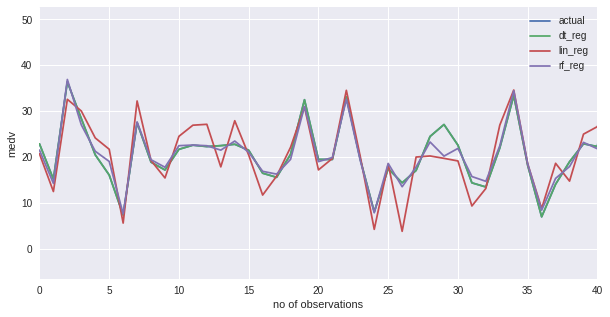

In [21]:
h= np.asarray(h)
df = pd.DataFrame({'actual': h,  'dt_reg' : h2, 'lin_reg': h1, 'rf_reg': h3})
sns.set_style("darkgrid")
x = df.plot(kind='line', figsize=(10,5), xlim = (0,40))
plt.xlabel('no of observations')
plt.ylabel('medv')
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_grid = {"max_features": randint(1, 11), 'n_estimators': randint(10,100,10) }
rf_reg2 = RandomForestRegressor(random_state = 42)
random_search = RandomizedSearchCV(rf_reg3, param_grid)
x = random_search.fit(boston_transformed, lab_train)

final_model = random_search.best_estimator_
boston_transformed = pipeline.transform(fea_train)
predictions = final_model.predict(boston_transformed)
meanerror(lab_train,predictions)
crossval(rf_reg2, boston_transformed, lab_train)

In [ ]:
final_model = random_search.best_estimator_
test_transformed = pipeline.transform(fea_test)
predictions = final_model.predict(test_transformed)
meanerror(lab_test,predictions), random_search.best_params_